In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

from tensorflow import keras
import tensorflow as tf

import collections
from collections import Counter
from wordcloud import WordCloud 

import flair
from flair.data import Sentence

import nltk
from nltk.corpus import stopwords

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
pd.options.display.max_rows = None

In [2]:
reviews = pd.read_csv('reviews.csv')

In [3]:
data = reviews.copy()

In [4]:
data.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


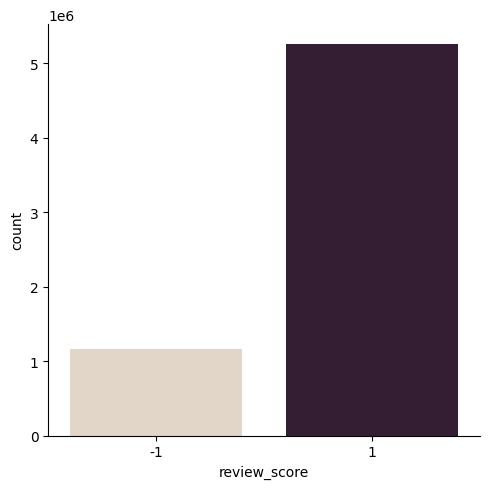

In [5]:
sns.catplot(x="review_score", kind="count", palette="ch:.25", data=data)

#### Most Reviewed Games

In [6]:
data = data.drop_duplicates(keep='first')

In [7]:
top_review_count = pd.value_counts(data.app_name)[:15].to_frame('count').reset_index() # top 15 games by review count
top_games = top_review_count['index'].tolist() # list of top 15 games by review count
top_review_count

,index,count
0,Terraria,78276
1,PAYDAY 2,63577
2,Dota 2,50190
3,Undertale,48512
4,Warframe,44970
5,Rocket League,39035
6,Left 4 Dead 2,35406
7,Grand Theft Auto V,30213
8,Arma 3,29854
9,BioShock Infinite,29770


In [8]:
top_reviews = data[data['app_name'].isin(top_games)] # take only top games reviews from data

In [9]:
top_review_count

,index,count
0,Terraria,78276
1,PAYDAY 2,63577
2,Dota 2,50190
3,Undertale,48512
4,Warframe,44970
5,Rocket League,39035
6,Left 4 Dead 2,35406
7,Grand Theft Auto V,30213
8,Arma 3,29854
9,BioShock Infinite,29770


In [10]:
x, y = 'app_name', 'review_score'
df1 = top_reviews.groupby(x)[y].value_counts(normalize=True) # group by game name and review score
df1 = df1.mul(100) # convert to percentage
df1 = df1.rename('percent').reset_index() # rename column

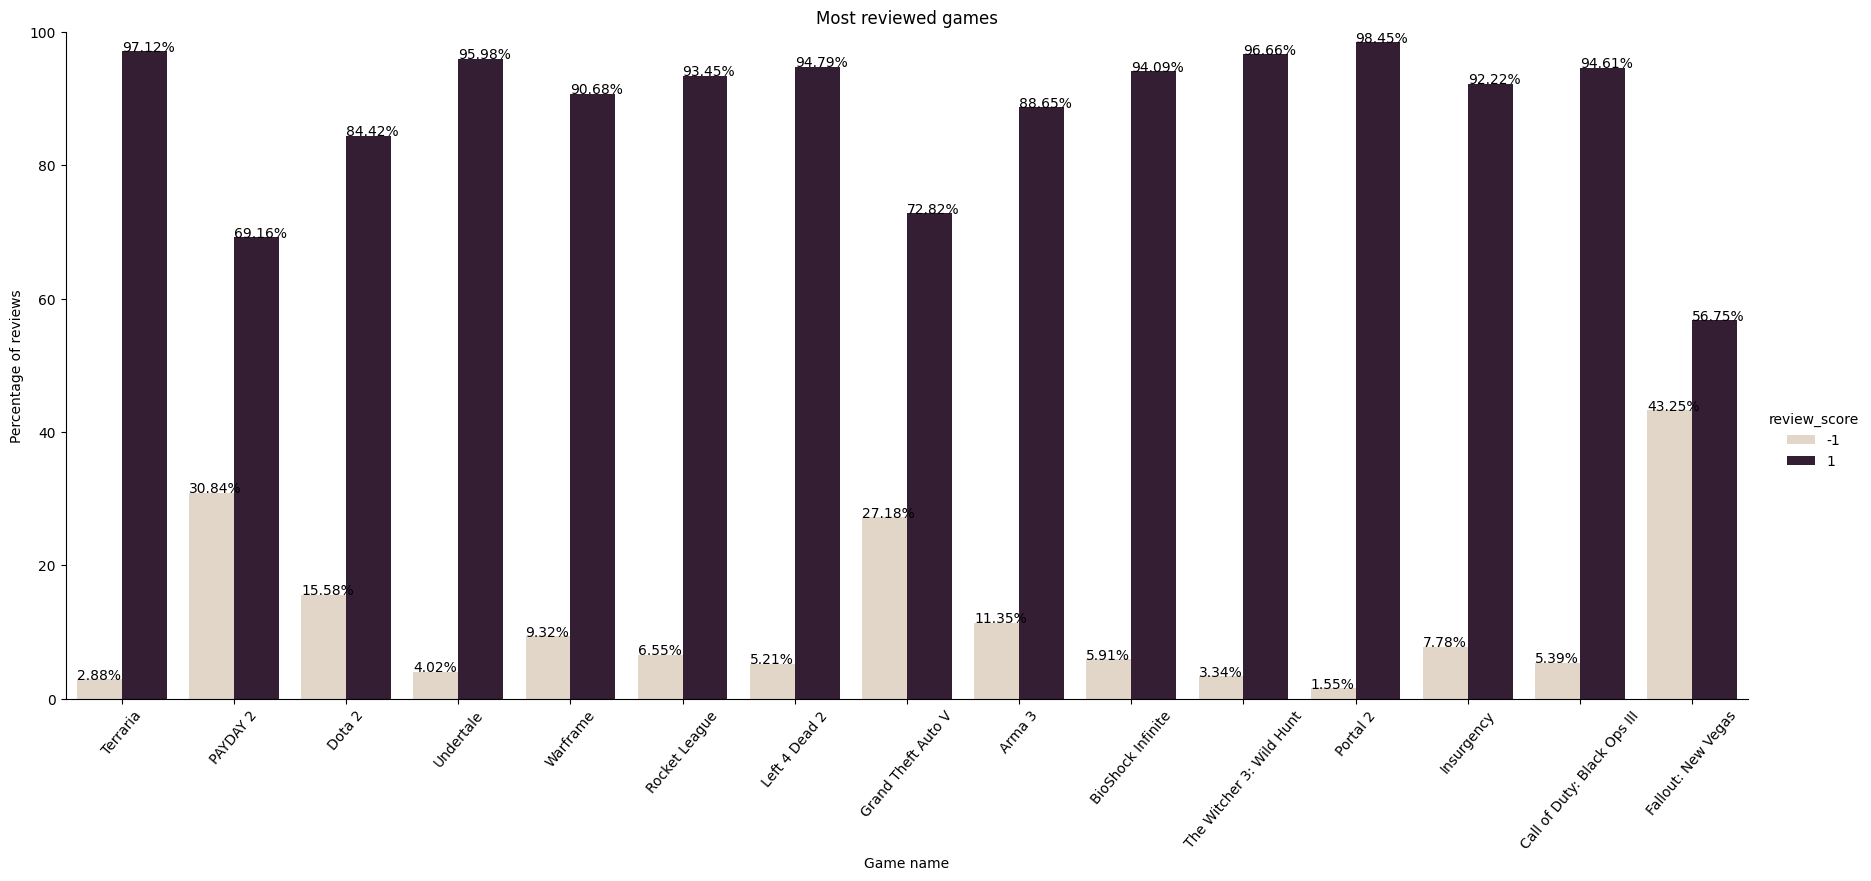

In [11]:
g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=7.4, aspect=2.4, order=top_reviews['app_name'].value_counts().index, palette='ch:.25') 
g.set(title='Most reviewed games', xlabel='Game name', ylabel='Percentage of reviews') 
g.ax.set_ylim(0,100) 
g.ax.set_xticklabels(top_review_count['index'], rotation=50)

for p in g.ax.patches: # add percentage text to plot
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

#### Games with 100% Positive Reviews

In [12]:
reviews_per_game = pd.value_counts(data.app_name).to_frame('count').reset_index() # count reviews per game
#games_count[games_count['count'] < 20] # 2511 games with less than 20 reviews

selected_games = reviews_per_game[reviews_per_game['count'] > 50] # select games with more than 50 reviews
selected_games = selected_games['index'].values # list of selected games
games = data['app_name'].unique() # all games

print('selected', len(selected_games), 'out of', len(games)) # 2511 games with less than 20 reviews

selected 4474 out of 9364


In [13]:
game_score = pd.concat([data.pop(x) for x in ['app_name', 'review_score']], axis=1) # take only game name and review score
game_score = game_score[game_score['app_name'].isin(selected_games)].reset_index(drop=True) # take only selected games

In [14]:
x, y = 'app_name', 'review_score'
df1 = game_score.groupby(x)[y].value_counts(normalize=True) # group by game name and review score
df1 = df1.mul(100) # convert to percentage
df1 = df1.rename('percent').reset_index() # rename column

game_score = df1.drop(df1[df1['review_score'] == -1].index) # drop reviews with negative score
game_score = game_score.drop('review_score', 1) # drop review score column
game_score.sort_values('percent').reset_index(drop=True) # sort by percentage

C:\Users\Swapn\AppData\Local\Temp\ipykernel_33064\2788406402.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  game_score = game_score.drop('review_score', 1) # drop review score column


,app_name,percent
0,Mafia III: Definitive Edition,5.417815
1,Patterns,7.058824
2,Adventure Park,8.988764
3,Kinetic Void,9.562399
4,Better Late Than DEAD,9.574468
5,Kick-Ass 2,9.589041
6,Otherland,10.000000
7,Game Tycoon 1.5,10.101010
8,Flatout 3,11.214953
9,The Shopkeeper,11.320755


In [15]:
best_games = game_score[game_score['percent'] == 100] # 20 games have 100% positive reviews with 50 or more reviews
best_games

,app_name,percent
296,Age of Empires® III (2007),100.0
757,BLUE REVOLVER,100.0
800,Batman: Arkham City GOTY,100.0
931,Bit Blaster XL,100.0
2084,Deus Ex: Game of the Year Edition,100.0
2621,Everyday Genius: SquareLogic,100.0
3582,Hexcells Infinite,100.0
3729,Hyperdimension Neptunia Re;Birth3 V Generation,100.0
4028,Keep Talking and Nobody Explodes,100.0
4243,Lazerbait,100.0


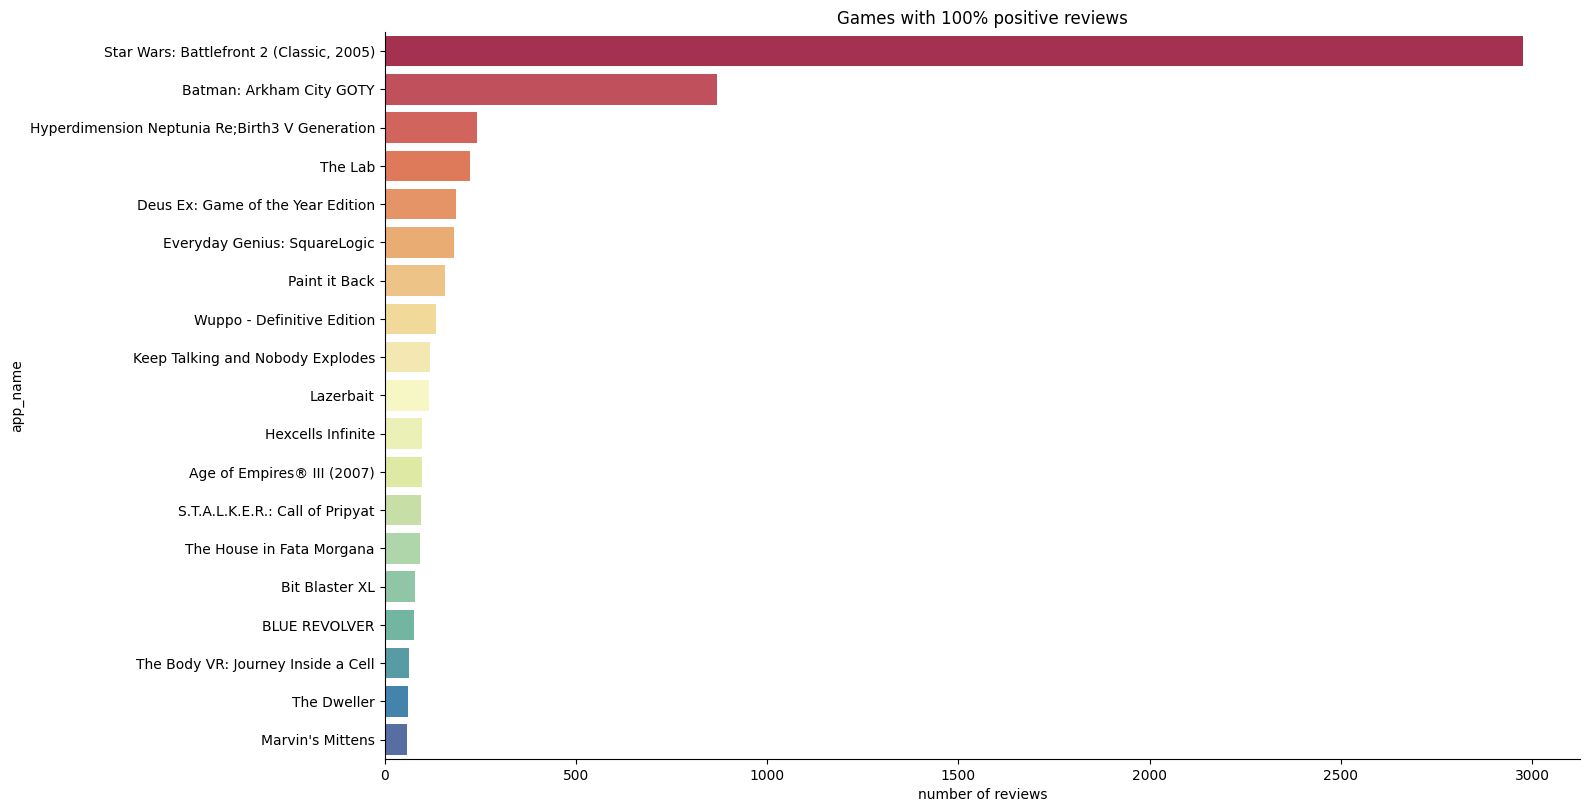

In [16]:
t = reviews[reviews['app_name'].isin(best_games['app_name'].values)] # take only reviews of best games
sns.catplot(y='app_name', kind='count', data=t, height=8, aspect=2, order=t['app_name'].value_counts().index, palette='Spectral').set(xlabel='number of reviews').set(title='Games with 100% positive reviews')
plt.show()

#### Games with 85%+ negative reviews

In [17]:
worst_games = game_score[game_score['percent'] < 15].sort_values('percent')
worst_games

,app_name,percent
4491,Mafia III: Definitive Edition,5.417815
5367,Patterns,7.058824
265,Adventure Park,8.988764
4064,Kinetic Void,9.562399
882,Better Late Than DEAD,9.574468
4044,Kick-Ass 2,9.589041
5236,Otherland,10.000000
3095,Game Tycoon 1.5,10.101010
2901,Flatout 3,11.214953
7738,The Shopkeeper,11.320755


In [18]:
t = reviews[reviews['app_name'].isin(worst_games['app_name'].values)] # take only reviews of worst games

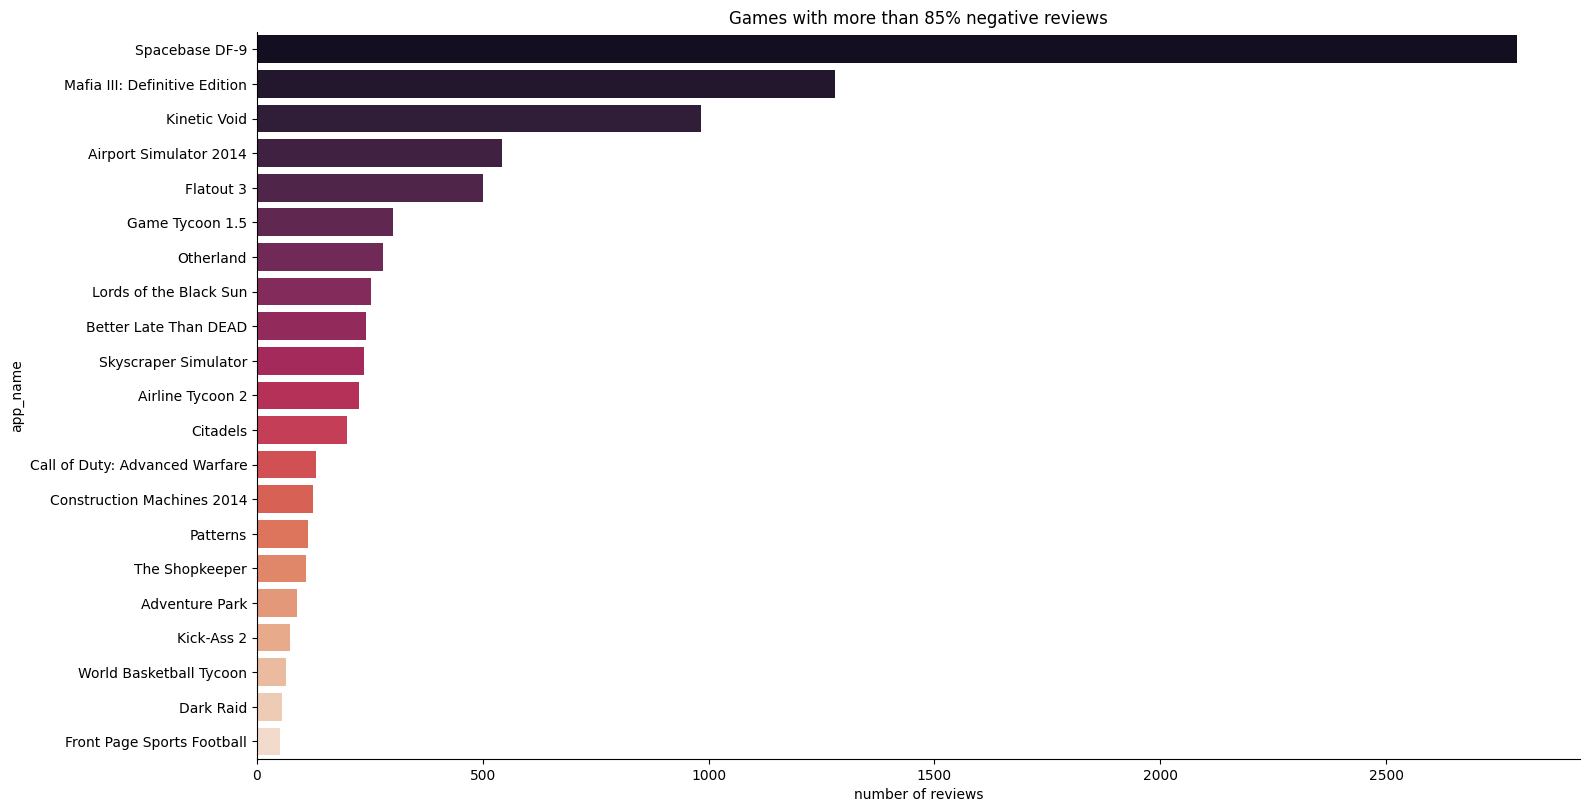

In [19]:
sns.catplot(y='app_name', kind='count', palette='rocket', data=t, height=8, aspect=2, order=t['app_name'].value_counts().index).set(title='Games with more than 85% negative reviews').set(xlabel='number of reviews')
plt.show()

## Sentimental Analysis

In [20]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [21]:
reviews = reviews.drop(reviews.loc[reviews.app_name.isna()].index)

In [22]:
reviews.review_text = reviews.review_text.astype('str') # convert review text to string

In [23]:
game_check = reviews.loc[reviews['app_name'].str.contains("fantasy", case=False)] # check if there are any reviews for specific game
"""
Games to filter out:
1. Counter-Strike
2. Dota 2
3. Team Fortress 2
4. Grand Theft Auto V
5. Tom Clancy's Rainbow Six Siege
6. Left 4 Dead 2
7. War Thunder
8. FINAL FANTASY XIV Online
9. The Witcher 3: Wild Hunt
10. Call of Duty: Modern Warfare 2
""" 

"\nGames to filter out:\n1. Counter-Strike\n2. Dota 2\n3. Team Fortress 2\n4. Grand Theft Auto V\n5. Tom Clancy's Rainbow Six Siege\n6. Left 4 Dead 2\n7. War Thunder\n8. FINAL FANTASY XIV Online\n9. The Witcher 3: Wild Hunt\n10. Call of Duty: Modern Warfare 2\n"

In [24]:
game_check.app_name.unique() # check if there are any reviews for specific game

array(['FINAL FANTASY® XI: Ultimate Collection Seekers Edition NA',
       'FINAL FANTASY® XI: Ultimate Collection Seekers Edition ROW',
       'Final Fantasy III (3D Remake)', 'Fantasy Grounds Classic',
       'Epic Battle Fantasy 4', 'Fearless Fantasy', 'FINAL FANTASY XIII',
       'FINAL FANTASY XIII-2', 'Wildlife Park 2 - Fantasy',
       'Final Fantasy IV (3D Remake)',
       'Dragon Fantasy: The Volumes of Westeria',
       'FINAL FANTASY TYPE-0 HD', 'LIGHTNING RETURNS: FINAL FANTASY XIII',
       'FINAL FANTASY IV: THE AFTER YEARS',
       'FINAL FANTASY X/X-2 HD Remaster', 'Sakura Fantasy Chapter 1',
       'FINAL FANTASY IX', 'FINAL FANTASY VII', 'FINAL FANTASY VIII',
       'FINAL FANTASY XIV Online', 'Fantasy Tales Online',
       'Fantasy Kingdom Simulator', 'Epic Battle Fantasy 3',
       'Fantasy Wars'], dtype=object)

In [25]:
data2 = reviews[reviews.app_name.isin(['Counter-Strike', 'Dota 2', 
                                       'Team Fortress 2', 
                                       'Grand Theft Auto V', 
                                       'Tom Clancy\'s Rainbow Six Siege', 
                                       'Left 4 Dead 2', 
                                       'War Thunder', 
                                       'The Witcher 3: Wild Hunt', 
                                       'FINAL FANTASY XIV Online', 
                                       'Call of Duty: Modern Warfare 2'])] # take only reviews of specific games

In [26]:
data2.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


### WordCloud

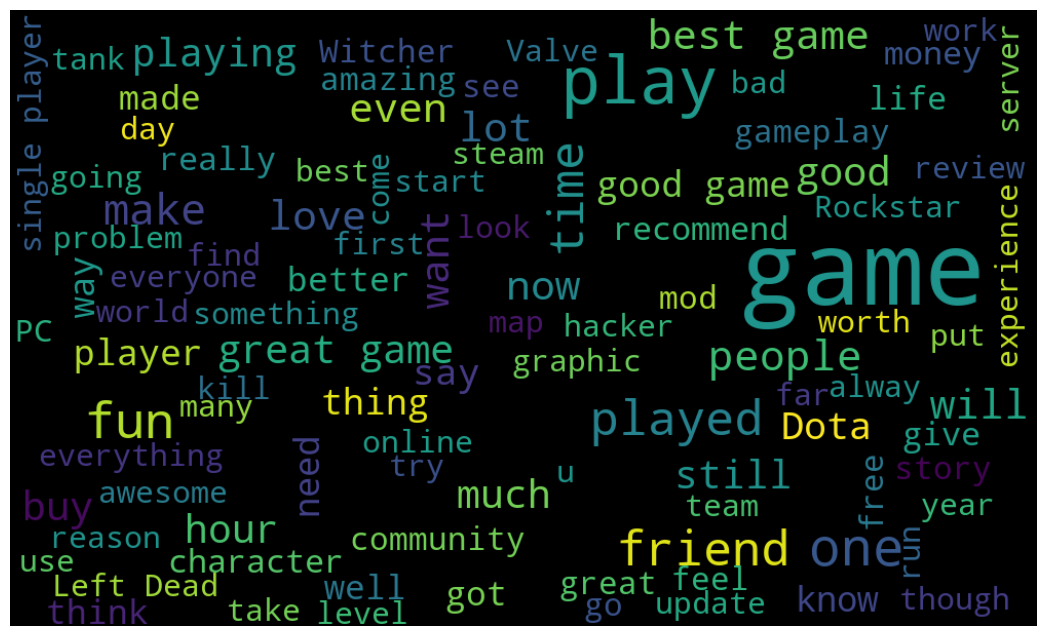

In [27]:
txt = ' '.join(rev for rev in data2.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### WordCloud of Each Sentiment Review Text

In [28]:
positive_review = data2[data2['review_score']==1]
negative_review = data2[data2['review_score']==-1]

#### Positive Sentiment Reviews

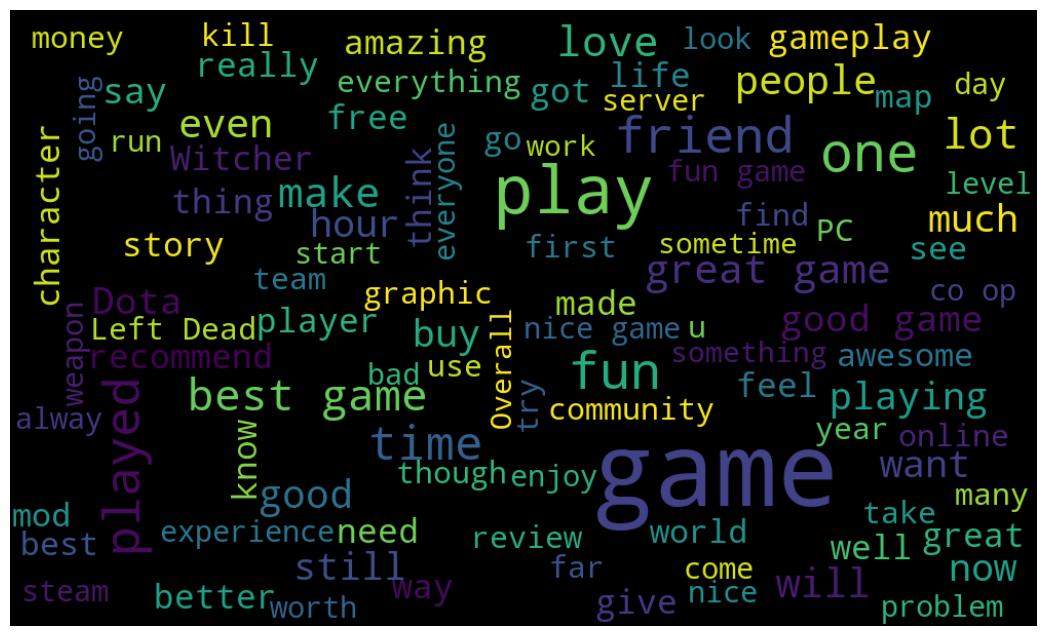

In [29]:
txt = ' '.join(rev for rev in positive_review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Negative Sentiment Reviews

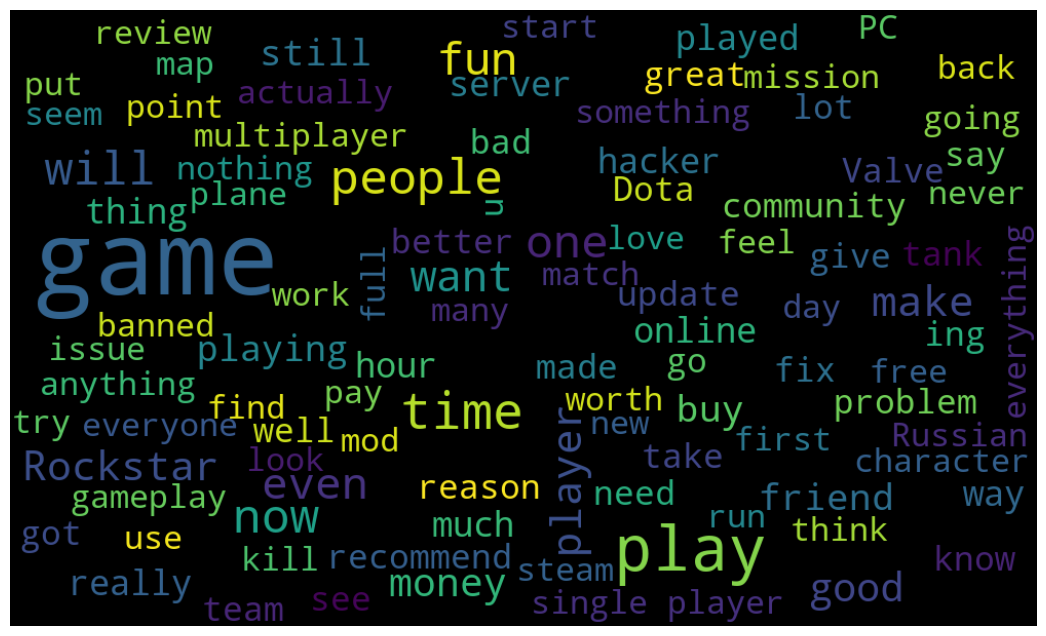

In [30]:
txt = ' '.join(rev for rev in negative_review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

From the both wordclouds of each sentiment above we can see that there are words like "early" or "access" that dominate our review words. We will drop them.

In [31]:
data2 = data2.drop(data2[data2.review_text == 'Early Access Review'].index) # drop reviews with Early Access Review text

#### Distribution of Number of Review Words

##### First we create additional features to count number of words in each review text

In [32]:
review_vis = data2.copy()
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split())) # number of words in review

<Axes: xlabel='Num_word_review', ylabel='Count'>

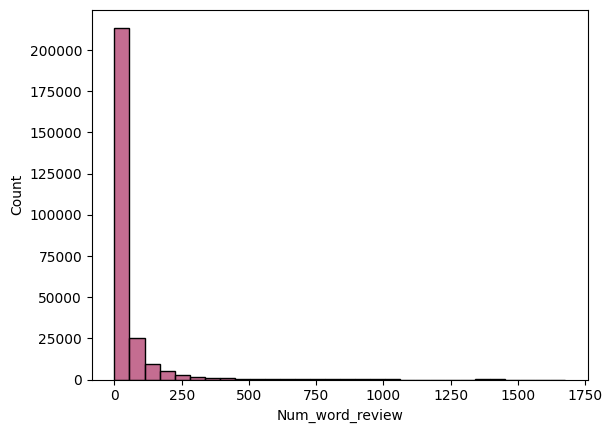

In [33]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='#b13c6c') # plot histogram of number of words in review

As we can see that most of our review texts contain 1-200 words.

In [34]:
data2.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [35]:
selectedGamesScore = pd.DataFrame(data2['review_score'].value_counts()).reset_index()
selectedGamesScore

,index,review_score
0,1,224864
1,-1,37559


In [36]:
selectedGamesScore['Percent'] = (selectedGamesScore['review_score'] / selectedGamesScore['review_score'].sum()) *100
selectedGamesScore

,index,review_score,Percent
0,1,224864,85.687611
1,-1,37559,14.312389


In [37]:
selectedGamesScore['index'] = selectedGamesScore['index'].replace([-1], 'Negative')

In [38]:
selectedGamesScore['index'] = selectedGamesScore['index'].replace([1], 'Positive')

In [39]:
selectedGamesScore

,index,review_score,Percent
0,Positive,224864,85.687611
1,Negative,37559,14.312389


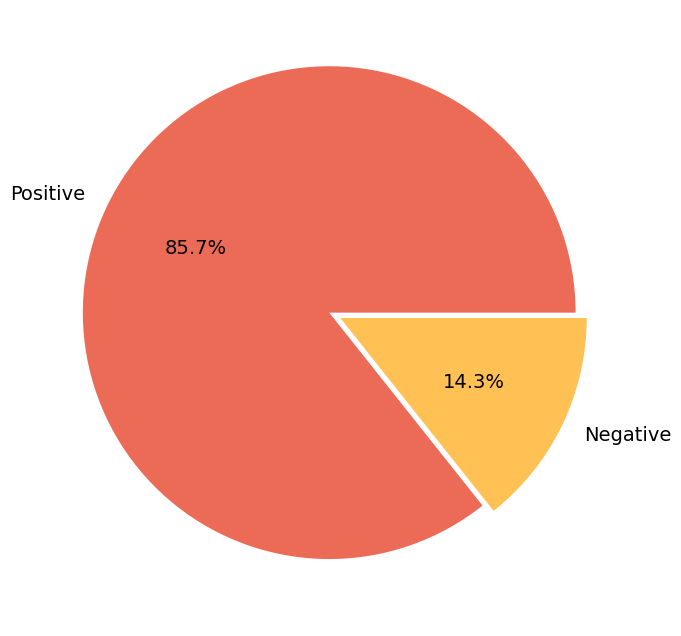

In [40]:
plt.figure(figsize = (8,8))
plt.pie(selectedGamesScore['review_score'], labels = selectedGamesScore['index'], autopct = '%1.1f%%', 
        colors = ['#EC6B56', '#FFC154', '#47B39C'], textprops={'fontsize': 14}, explode = [0.05, 0])
plt.show()

In [41]:
top_review_count = pd.value_counts(data2.app_name)[:15].to_frame('count').reset_index() # top 15 games by review count
top_games = top_review_count['index'].tolist() # list of top 15 games by review count
top_review_count

,index,count
0,Dota 2,73541
1,Left 4 Dead 2,50980
2,Grand Theft Auto V,42374
3,The Witcher 3: Wild Hunt,31853
4,Tom Clancy's Rainbow Six Siege,17681
5,Counter-Strike,12353
6,Team Fortress 2,12220
7,War Thunder,9426
8,Call of Duty: Modern Warfare 2,7946
9,FINAL FANTASY XIV Online,4049


In [42]:
top_reviews = data2[data2['app_name'].isin(top_games)] # take only top games reviews from data

In [43]:
x, y = 'app_name', 'review_score'
df1 = data2.groupby(x)[y].value_counts(normalize=True) # group by game name and review score
df1 = df1.mul(100) # convert to percentage
df1 = df1.rename('percent').reset_index() # rename column

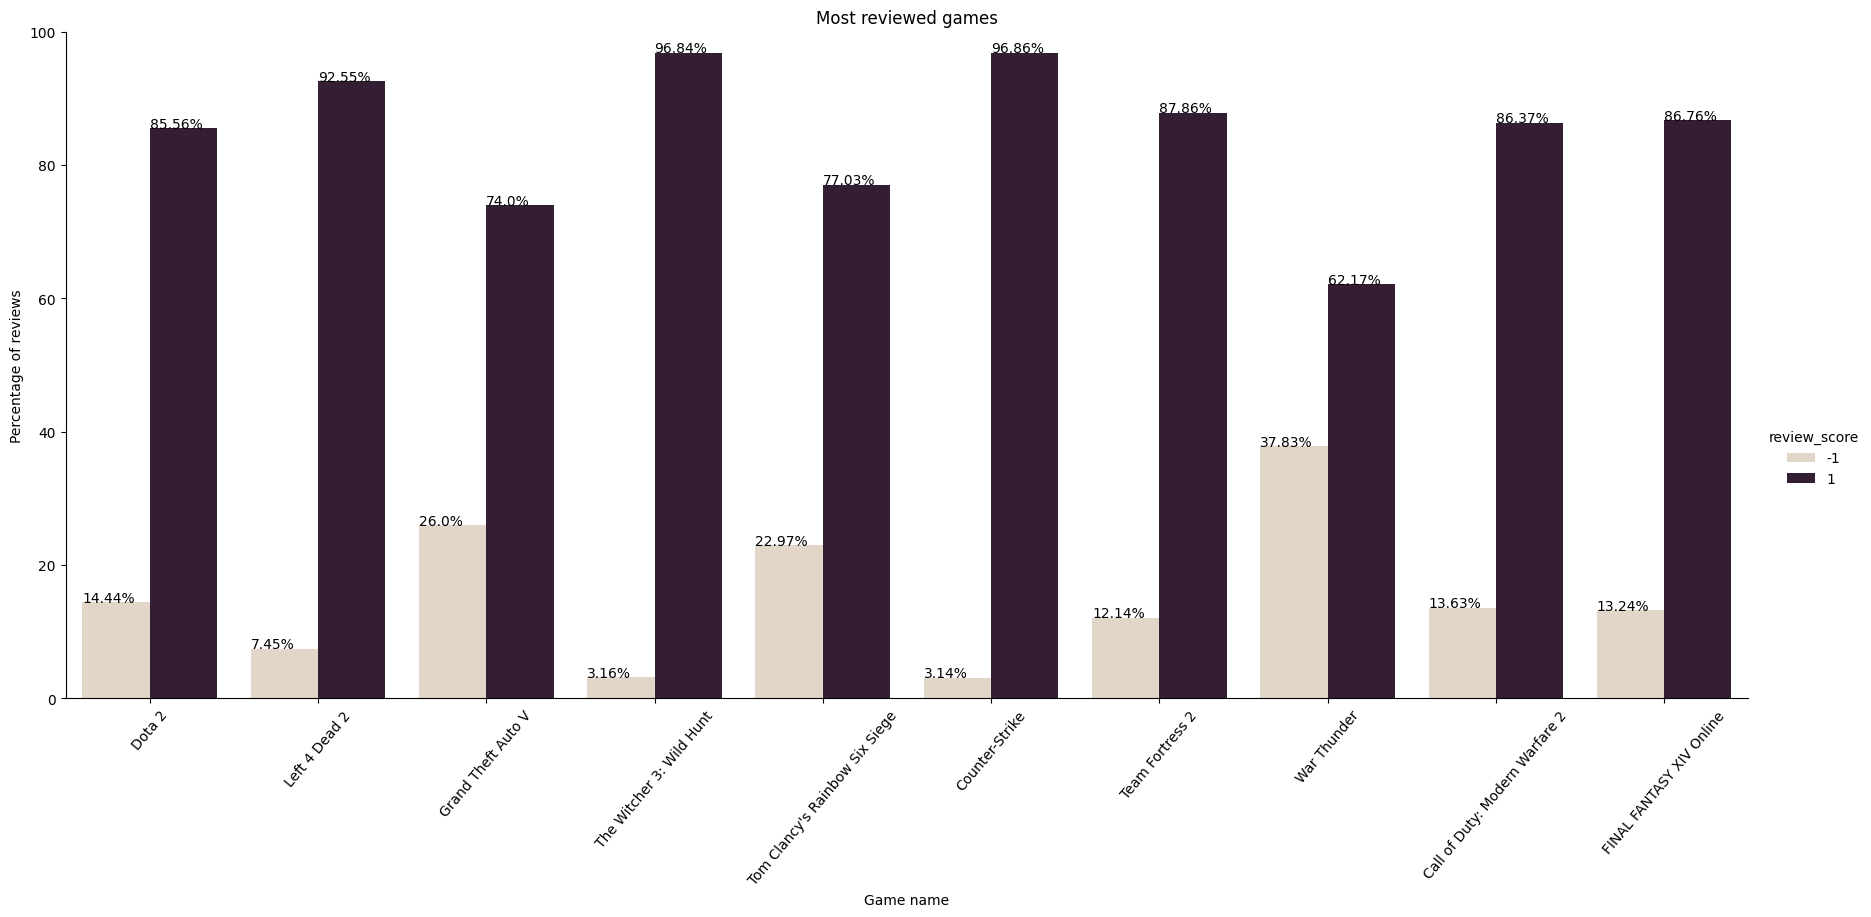

In [44]:
g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=7.4, aspect=2.4, order=data2['app_name'].value_counts().index, palette='ch:.25') 
g.set(title='Most reviewed games', xlabel='Game name', ylabel='Percentage of reviews') 
g.ax.set_ylim(0,100) 
g.ax.set_xticklabels(top_review_count['index'], rotation=50)

for p in g.ax.patches: # add percentage text to plot
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## Data Cleaning For Sentiment Processing

In [45]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
data2.isnull().sum()

app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

In [47]:
data2 = data2.drop_duplicates(keep='first') # drop duplicate reviews

In [48]:
data2.shape

(194900, 5)

In [49]:
def clean(raw): # clean review text
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [50]:
def remove_num(texts): # remove numbers from review text
   output = re.sub(r'\d+', '', texts)
   return output

In [51]:
def deEmojify(x): # remove emojis from review text
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [52]:
def unify_whitespaces(x): # unify whitespaces in review text
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [53]:
def remove_symbols(x): # remove symbols from review text
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [54]:
def remove_punctuation(text): # remove punctuation from review text
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [55]:
stop=set(stopwords.words("english")) # set of stopwords
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text): # remove stopwords from review text
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text) 

In [56]:
def Stemming(text): # stemming review text
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [57]:
def cleaning(df,review): # apply all cleaning functions to review text
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

In [58]:
cleaning(data2,'review_text') # clean review text

In [59]:
data2[['review_text']].head(20)

,review_text
0,ruin life
1,experi game type review say thing like great g...
2,game save virgin
3,like origin game like game lag like game run l...
4,easi learn hard master
5,r revolv play
6,still better call duti ghost
7,cant buy skin case key sticker gaben cant stea...
8,counter strike ok year unlimit fun friend fina...
9,everi server spanish french fluentli swear lan...


Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [60]:
review_vis = data2.copy()
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split()) # split review text into words and store in temp_list column
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist]) # count the number of words in temp_list column
temp = pd.DataFrame(top.most_common(20)) # create dataframe of top 20 most common words in review text
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,271261
1,play,101929
2,get,46388
3,like,43314
4,good,38244
5,one,36633
6,best,35976
7,fun,35243
8,time,34737
9,great,30643


<Axes: xlabel='count', ylabel='Common_words'>

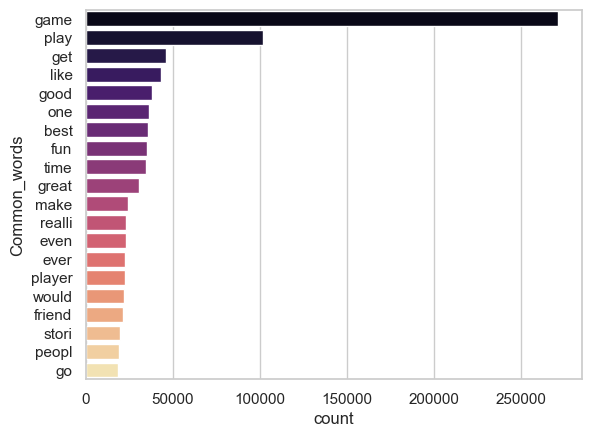

In [61]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp, palette='magma')

## Creating Bag of Words and Text Classifier Model

#### Creating pipeline for tokenizing and modelling

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

In [63]:
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=4000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ]) # create pipeline for random forest classifier model

In [64]:
X = data2['review_text']
y = data2['review_score']

In [65]:
Counter(y) # count number of reviews for each score

Counter({1: 167072, -1: 27828})

#### Tokenizing and Model Training

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 43, test_size = 0.25) # split data into training and testing sets

In [67]:
text_classifier = clf.fit(X_train,y_train)

In [68]:
predictions = text_classifier.predict(X_test)

#### Model's Performance

In [69]:
confusion_matrix(y_test,predictions)

array([[ 2557,  4415],
       [  924, 40829]], dtype=int64)

In [70]:
def Confusion_Matrix(y_test,ypred): # create confusion matrix for model
    cfmat = confusion_matrix(y_test,ypred)
    print('Confusion Matrix: \n',classification_report(y_test,ypred,labels=[1,-1]))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[1,0]))
    print('FN - False Negative {}'.format(cfmat[0,1]))
    print('TP - True Positive {}'.format(cfmat[0,0]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [71]:
Confusion_Matrix(y_test,predictions) # print confusion matrix for model

Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.90      0.98      0.94     41753
          -1       0.73      0.37      0.49      6972

    accuracy                           0.89     48725
   macro avg       0.82      0.67      0.71     48725
weighted avg       0.88      0.89      0.87     48725



TN - True Negative 40829
FP - False Positive 924
FN - False Negative 4415
TP - True Positive 2557
Accuracy Rate: 0.8904258594150847
Misclassification Rate: 0.10957414058491534
F1-Score: 0.7139338035829197
ROC-AUC 0.6723112894248349


<Axes: >

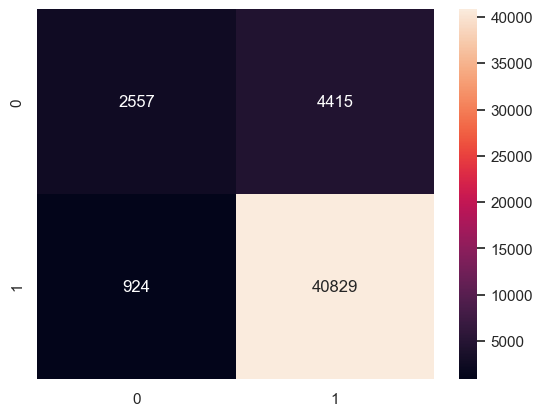

In [72]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='') # plot confusion matrix for model